### Above ground biomass (AGB) for 2021

##### Estimation of Forest Aboveground Biomass (AGB) Density In Uganda's Forested regions using Remote sensing and Machine Learning Methods

Description:
The estimation of Aboveground biomass (AGB) plays a crucial role in understanding the dynamics of the carbon cycle and climate change in the terrestrial ecosystem at large. Using remote sensing techniques, great success has been recorded in AGB estimation at local and global scales.
This script employs Remote sensed data, including Global Ecosystem Dynamics Investigation (GEDI) L4B, Sentinel-1, Sentinel-2, Copernicus elevation, and slope datasets, to create a model for the Estimation Above Ground Biomass (AGB) density in Uganda's forested regions.

Independent Variable:
The GEDI L4B product provides 1 km x 1 km estimates of mean AGB density.

Dependent Variables:
1. Interquartile range (IQR) for the VV (vertical transmit and vertical receive) polarization data.
2. Interquartile range (IQR) for the VH (vertical transmit and horizontal receive) polarization data.
3. Slope.
4. Elevation.
5. Cloud-filtered median composite bands of the optical Sentinel II images.

Machine Learning Method:
The script utilizes the Random Forest (RF) classifier to model the relationship between the independent and dependent variables, facilitating the prediction of AGB density.

Temporal Scope:
The script focuses on modeling AGB density for the period from 2021-04-01 to 2021-07-30, considering the availability of GEDI data during this timeframe.

In [57]:
import os
import subprocess
import calendar
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import geemap



# Earth Engine module
try:
    import ee
except ImportError:
    print('Installing ee ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'earthengine-api'])
    
# This module extends Google Earth Engine functionality
try:
    import eemont
except ImportError:
    print('Installing eemont ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'eemont'])  

In [58]:
ee.Authenticate()
ee.Initialize()
#Please follow intructions to get the authorisation code from Google earth engine

### 1. Import Study area
For this study, we chose Kibaale district as a case study. Kibaale District is located in western Uganda and currently inhabits a total of 19 forest reserves.

In [59]:
featureAsset = 'projects/ee-edwig/assets/Uganda'
demarcationType = 'DName2016'
regionName = 'KIBAALE'
roi = ee.FeatureCollection(featureAsset) \
        .filter(ee.Filter.eq(demarcationType, regionName))

### 2. Load raster variables (Sentinel-1, Sentinel-2, Elevation, ESA World Cover)

#### 2.1 Load Sentinel 1 (GRD) 

In [60]:
# Load Sentinel-1 for the post-rainy season.
S1_PRS = (ee.ImageCollection('COPERNICUS/S1_GRD')
    .filterDate('2021-04-01', '2021-07-30')
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
    .filterBounds(roi))

Calculate the interquartile range (IQR) for the VV (vertical transmit and vertical receive) and VH (vertical transmit and horizontal receive) polarization. The IQR is a measure of Sentinel-1 backscatter variability.

In [61]:
S1_PRS_pc = S1_PRS.reduce(ee.Reducer.percentile([25, 50, 75]))
S1_PRS_pc = ee.Image(10).pow(S1_PRS_pc.divide(10))
S1_PRS_pc_Feats = S1_PRS_pc.select(['VH_p50', 'VV_p50']).clip(roi)

# Reproject to WGS 84 UTM zone 36N
S1_PRS_pc_Feats = S1_PRS_pc_Feats.reproject(crs='EPSG:21096', scale=30)

# Calculate IQR for the VV polarization
PRS_VV_iqr = S1_PRS_pc_Feats.addBands(
    (S1_PRS_pc.select('VV_p75').subtract(S1_PRS_pc.select('VV_p25'))).rename('VV_iqr'))

# Calculate IQR for the VH polarization
PRS_VH_iqr = S1_PRS_pc_Feats.addBands(
    (S1_PRS_pc.select('VH_p75').subtract(S1_PRS_pc.select('VH_p25'))).rename('VH_iqr'))

Visualize the VV and VH datasets.

In [62]:
Map = geemap.Map()
Map.addLayer(PRS_VV_iqr.clip(roi), {'bands': 'VV_iqr', min: 0,max: 0.1}, 'Sentinel-1 IW VV');
Map.addLayer( PRS_VH_iqr.clip(roi), {'bands': 'VH_iqr', min: 0,max: 0.1}, 'Sentinel-1 IW VH');

#### 2.2 Load Sentinel II (Optical RS Data) 

Define a cloud masking function using Sentinel-2 QA band.

The QA60 is a bitmask band with cloud mask information (Bits 10 and 11). Bit 10 represents 'Opaque clouds,' where 0 means 'No opaque clouds' and 1 means' Opaque clouds present'. Bit 11 represents 'Cirrus clouds,' where "0 means 'No cirrus clouds' and 1 means' Cirrus clouds present'.

In [63]:
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = ee.Number(2).pow(10).int()
    cirrusBitMask = ee.Number(2).pow(11).int()

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
        qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Return the masked and scaled data.
    return image.updateMask(mask).divide(10000)

Filter the ImageCollection by date, cloud cover ('CLOUDY_PIXEL_PERCENTAGE'), cloud mask and selet the bands  to use.

In [64]:
composite = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterDate('2021-04-01', '2021-07-30') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .map(maskS2clouds) \
    .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12'])

S2Composite = composite.median().clip(roi).reproject(crs='EPSG:21096', scale=30)

Visualize the VV, VH datasets and optical satellite image.

In [65]:
Map.addLayer(S2Composite, {'bands': ['B11', 'B8', 'B3'], 'min': 0, 'max': 0.3}, 'Optical Image')

#### 2.3 Load Copernicus DEM (Digital Elevation Model and Calculate Slope )

In [66]:
Elevation = ee.ImageCollection('COPERNICUS/DEM/GLO30') \
    .select('DEM') \
    .median() \
    .clip(roi) \
    .reproject(crs='EPSG:21096', scale=30)

Slope = ee.Terrain.slope(Elevation) \
        .clip(roi) \
        .reproject(crs='EPSG:21096', scale=30) 

max_elevation = Elevation.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=roi,
    scale=30
).get('DEM').getInfo()

max_slope = Slope.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=roi,
    scale=30
).get('slope').getInfo()

Visualize the VV, VH, optical satellite image, DEM and Slope.

In [67]:
Map.addLayer(Elevation, {'min': 0, 'max': max_elevation, 'palette': ['blue', 'green', 'yellow', 'red']}, 'Elevation')
Map.addLayer(Slope, {'min': 0, 'max': max_slope, 'palette': ['blue', 'green', 'yellow', 'red']}, 'Slope')

#### 2.4  ESA World Cover (2021) [https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200#bands]

In [68]:
ESAWorldCover = ee.ImageCollection("ESA/WorldCover/v200").first() \
                    .clip(roi)
#Extract forest areas from the land cover
forest_mask = ESAWorldCover.updateMask(ESAWorldCover.eq(10))
visualization = {'bands': ['Map'], 'palette': ['008000']}
Map.addLayer(forest_mask, visualization, "Trees")
Map.centerObject(roi, 12)
Map

Map(center=[0.8049178741846686, 31.066656837841602], controls=(WidgetControl(options=['position', 'transparent…

### 3. Combine raster variables.

In [69]:
mergedCollection = (S2Composite.addBands(PRS_VV_iqr)
    .addBands(PRS_VH_iqr)
    .addBands(Elevation)
    .addBands(Slope)
    .addBands(forest_mask))

# Clip to the output image to the study area boundary
clippedMergedCollection = mergedCollection.clip(roi)

# Create an object (bands) that contains all raster variables
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12','VV_iqr','VH_iqr', 'DEM', 'slope', 'Map']

### 4. Prepare training data

#### 4.1 Load GEDI L4B Gridded Aboveground Biomass Density data

In [70]:
#Mean aboveground biomass density (MU)
l4b = ee.Image('LARSE/GEDI/GEDI04_B_002').select('MU').clip(roi).reproject(crs='EPSG:27429', scale=30)
l4bVisualization= {'min': 10, 'max': 250, 'palette': ['#440154', '#414387', '#2a788e', '#23a884', '#7ad151', '#fde725']}
Map = geemap.Map()
Map.addLayer(l4b, l4bVisualization,'Mean Biomass')

### 4.2 Extract sample points from l4b dataset for the Random forest model

In [71]:
points = l4b.sample(
    region=roi,
    scale=100,
    numPixels=1000,
    geometries=True
)
Map.addLayer(points, {'color': 'red'}, 'Sampled Points')
Map.centerObject(roi, 12)
Map

Map(center=[0.8049178741846686, 31.066656837841602], controls=(WidgetControl(options=['position', 'transparent…

#### 4.3 Split data for training (70%) and validation (30%)

In [72]:
dataWithColumn = points.randomColumn('random', 27)

# Split the training data set into training (70%) and validation or test (30%)
split = 0.7
trainingData = dataWithColumn.filter(ee.Filter.lt('random', split))
validationData = dataWithColumn.filter(ee.Filter.gte('random', split))

### 5. Train the random forest (RF) model

In [73]:
training = clippedMergedCollection.select(bands).sampleRegions(
    collection=trainingData,
    properties=['MU'],
    scale=10
)

# Train a random forest classifier for regression
classifier = ee.Classifier.smileRandomForest(100) \
    .setOutputMode('REGRESSION') \
    .train(
        features=training,
        classProperty="MU",
        inputProperties=bands
    )

# Run the classification and clip it to the boundary
regression = clippedMergedCollection.select(bands).classify(classifier, 'predicted').clip(roi)

In [74]:
# get dictionaries of min & max predicted value
regression_min = regression.reduceRegion(
    reducer=ee.Reducer.min(),
    scale=30,
    crs='EPSG:32735',
    geometry=roi,
    bestEffort=True,
    tileScale=5
)

regression_max = regression.reduceRegion(
    reducer=ee.Reducer.max(),
    scale=30,
    crs='EPSG:32735',
    geometry=roi,
    bestEffort=True,
    tileScale=5
)


visParamsAGBD = {
    'min': regression_min.getInfo()['predicted'],
    'max': regression_max.getInfo()['predicted'],
    'palette': ['#440154', '#414387', '#2a788e', '#23a884', '#7ad151', '#fde725'],
}

#megagrams per hectare (Mg/ha)
# Create a Map
Map = geemap.Map()
Map.addLayer(regression, {'palette': ['#440154', '#414387', '#2a788e', '#23a884', '#7ad151', '#fde725'], 'min': regression_min.getInfo()['predicted'], 'max': regression_max.getInfo()['predicted']}, 'Above Ground Biomass Density')
Map.centerObject(roi, 12)
Map.add_colorbar(visParamsAGBD, label="Above Groud Biomass Density (Mg/ha)" , orientation="horizontal")
Map.addLayerControl()
Map

Map(center=[0.8049178741846686, 31.066656837841602], controls=(WidgetControl(options=['position', 'transparent…

### 6. Calcuate the variable importance 

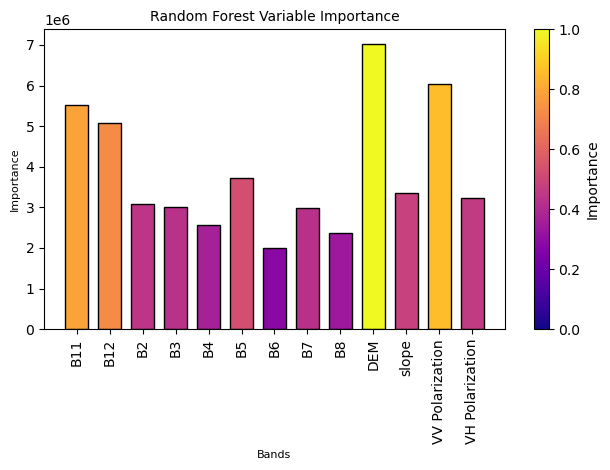

In [75]:
# Check model performance
classifier_details = classifier.explain()

# Explain the classifier with importance values
variable_importance = ee.Feature(None, ee.Dictionary(classifier_details).get('importance'))

# Get the data as a dictionary
importance_dict = variable_importance.getInfo()['properties']
importance_dict.pop('Map', None)
importance_dict['VV Polarization'] = importance_dict.pop('VV_iqr', None)
importance_dict['VH Polarization'] = importance_dict.pop('VH_iqr', None)

bands = list(importance_dict.keys())
importance = list(importance_dict.values()) 

# Extract bands and importance values
cmap = plt.cm.get_cmap('plasma')
normalized_importance = np.array(importance) / max(importance)
bars = plt.bar(bands, importance, color=cmap(normalized_importance), edgecolor='black', width=0.7, align='center')

# Add colorbar for reference

cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=cmap),
    ax=plt.gca()
)

cbar.set_label('Importance')

# Set axis labels and title
plt.xlabel('Bands', fontsize=8)
plt.ylabel('Importance', fontsize=8)
plt.xticks(rotation='vertical', fontsize=10)
plt.yticks(fontsize=10)
plt.title('Random Forest Variable Importance', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

### 7. Accuracy assessment

#### 7.2 Predicted vs Observed plot for Training data

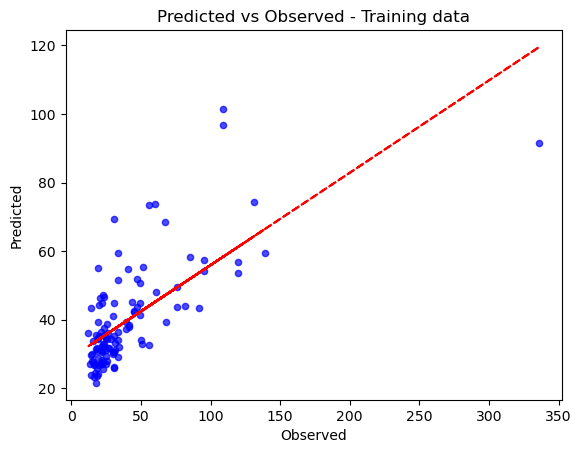

In [76]:
predicted_training = regression.sampleRegions(collection=trainingData, scale=30, geometries=True)

# Separate the observed ('MU') and predicted ('predicted') properties
sample_training = predicted_training.select(['MU', 'predicted'])

# Get the 'MU' and 'predicted' properties as numpy arrays
observed_values = np.array(predicted_training.aggregate_array('MU').getInfo())
predicted_values = np.array(predicted_training.aggregate_array('predicted').getInfo())

# Create a scatter plot
plt.scatter(observed_values, predicted_values, s=20, c='blue', alpha=0.7)

# Add a trendline
z = np.polyfit(observed_values, predicted_values, 1)
p = np.poly1d(z)
plt.plot(observed_values, p(observed_values), 'r--')

# Set axis labels and title
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Predicted vs Observed - Training data')

# Show the plot
plt.show()

#### 7.2 Predicted vs Observed plot for Validation data

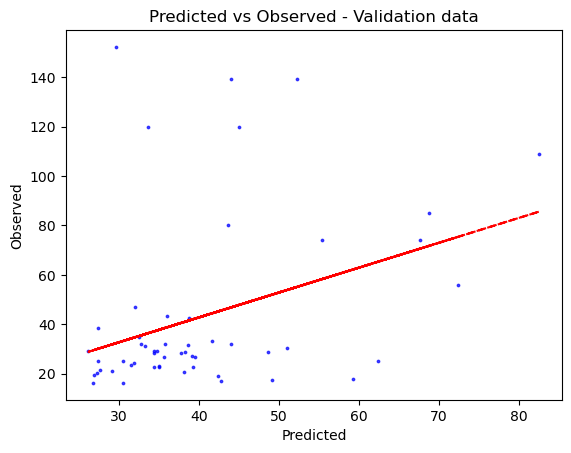

In [77]:
# Get predicted regression points in the same location as validation data
predicted_validation = regression.sampleRegions(collection=validationData, scale=30, geometries=True)

# Separate the observed ('MU') and predicted ('predicted') properties
sample_validation = predicted_validation.select(['MU', 'predicted'])
plt.scatter(sample_validation.aggregate_array('predicted').getInfo(), sample_validation.aggregate_array('MU').getInfo(), s=3, c='blue', alpha=0.7)
z = np.polyfit(sample_validation.aggregate_array('predicted').getInfo(), sample_validation.aggregate_array('MU').getInfo(), 1)
p = np.poly1d(z)
plt.plot(sample_validation.aggregate_array('predicted').getInfo(), p(sample_validation.aggregate_array('predicted').getInfo()), 'r--')

# Set axis labels and title
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.title('Predicted vs Observed - Validation data')

# Show the plot
plt.show()

#### 7.3 Compute RMS Error

In [53]:
observation_validation = ee.Array(sample_validation.aggregate_array('MU'))
prediction_validation = ee.Array(sample_validation.aggregate_array('predicted'))

# Compute residuals
residuals_validation = observation_validation.subtract(prediction_validation)
rmse_validation = residuals_validation.pow(2).reduce(ee.Reducer.mean(), [0]).sqrt()

# Print the RMSE
print('Validation RMSE', rmse_validation.getInfo())

Validation RMSE [32.726242338368344]
